In [1]:
from lammps import lammps
import numpy as np
import matplotlib.pyplot as plt
import tqdm

In [23]:
input_script = """
# Create BCC lattice
units metal
atom_modify map array sort 0 0.0
lattice bcc 3.185 origin 0.0 0.0 0.0
region box block 0 4 0 4 0 4
create_box 2 box
create_atoms 1 box
#displace_atoms all random 0.01 0.01 0.01 12345
set atom 60 type 2
set atom 61 type 2
set atom 62 type 2
set atom 63 type 2

pair_style snap
pair_coeff * * ../potentials/WX_step_0019.snapcoeff ../potentials/WX.snapparam W X
mass * 183.84
min_style fire
thermo 1
compute dD all snad/atom 4.7 0.99363 8 0.5 0.5 1 1 
run 0
"""


# Execute the input script in LAMMPS
lmp = lammps(cmdargs=["-log", "none", "-screen", "none"])
lmp.commands_string(input_script)

X0 = np.ctypeslib.as_array(lmp.gather("x", 1, 3)).reshape(-1, 3)
F0 = np.ctypeslib.as_array(lmp.gather("f", 1, 3)).reshape(-1, 3)

lmp.scatter("x",1,3,np.ctypeslib.as_ctypes(X0.flatten()))

dD = np.ctypeslib.as_array(lmp.gather("c_dD", 1, 3*2*55)).reshape((-1, 2,3,55))[:,1]

print(X0.shape,dD.shape,np.abs(F0).max())



(128, 3) (128, 3, 55) 2.475797344914099e-14


In [24]:
def implicit_test(i=0):
    lmp.scatter("x", 1, 3, np.ctypeslib.as_ctypes(X0.flatten()))
    lmp.command("run 0")
    N = lmp.get_natoms()
    dD = np.ctypeslib.as_array(lmp.gather("c_dD", 1, 3*2*55)).reshape((-1, 2,3,55))[:,1]

    f0 = dD[:,:,i].flatten()
    alpha = 0.05/np.abs(f0).max()
    f0 *= alpha
    force = lambda :\
        np.ctypeslib.as_array(lmp.gather("f", 1, 3)).flatten() + f0
    
    X = X0.copy().flatten()
    
    f = force()
    while np.abs(f).max() > 1e-3:
        f = force()
        X += 0.02 * f
        lmp.scatter("x", 1, 3, np.ctypeslib.as_ctypes(X))
        lmp.commands_string("run 0")
        #print(np.abs(f).max(),np.linalg.norm(X-X0.flatten()))
    return X
implicit_dev_0=[]
for i in tqdm.tqdm(range(10)):
    implicit_dev_0 += [[implicit_test(i)]]

implicit_dev_0 = np.array(implicit_dev_0)




100%|██████████| 10/10 [00:02<00:00,  3.57it/s]


In [25]:
from scipy.optimize import root
def scipy_ID(i=0):
    lmp.scatter("x", 1, 3, np.ctypeslib.as_ctypes(X0.flatten()))
    lmp.command("run 0")
    N = lmp.get_natoms()
    dD = np.ctypeslib.as_array(lmp.gather("c_dD", 1, 3*2*55)).reshape((-1, 2,3,55))[:,1]

    f0 = dD[:,:,i].flatten()
    alpha = 0.05/np.abs(f0).max()
    f0 *= alpha

    def call(X):
        lmp.scatter("x", 1, 3, np.ctypeslib.as_ctypes(X))
        lmp.commands_string("run 0")
        return np.ctypeslib.as_array(lmp.gather("f", 1, 3)).flatten() + f0
    
    sol = root(call,X0.flatten(),method="hybr")
    return sol.x

implicit_dev=[]
for i in tqdm.tqdm(range(10)):
    implicit_dev += [[implicit_test(i)]]

implicit_dev = np.array(implicit_dev)



100%|██████████| 10/10 [00:02<00:00,  3.58it/s]


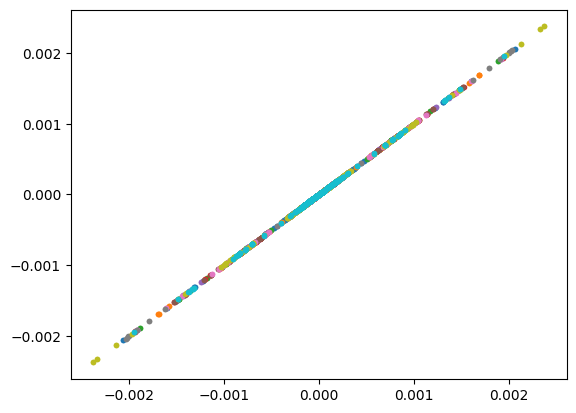

In [26]:
for i in range(10):
    plt.plot(implicit_dev_0[i].flatten()-X0.flatten(),\
             implicit_dev[i].flatten()-X0.flatten(),".")